# Fish Classification
In this project, i will build a neural network to classify seafoods. I'll use the “A Large Scale Fish Dataset” available on Kaggle for this. The dataset contains 9 different seafood types of that can be classified into 9 classes according to their types.

## Importing the required libraries

In [55]:
# Import Pandas and Matplotlib
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

# Import Label Encoder and train_test_split
from sklearn.preprocessing import LabelEncoder, minmax_scale
from sklearn.model_selection import train_test_split

# Import Path
from pathlib import Path
import os.path

import numpy as np
import struct
import warnings
warnings.filterwarnings('ignore')



## Dataset

In [56]:
label =[]
path=[]
fish_dir='/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for dir_name, _,filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png': #if filename contains .png
            if dir_name.split()[-1]!='GT': #if directory doesnt contain GT
               
                label.append(os.path.split(dir_name)[-1]) #append the directory name to label
                path.append(os.path.join(dir_name,filename)) #append all the png filest to path of that directory
data=pd.DataFrame(columns=['path','label'])
data['path']=path
data['label']=label
print(len(label), len(path))


9000 9000


In [57]:
# Use the head() function to display the first 5 rows of the data
data.head() 


path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel

In [58]:
# Print the shape of the data and labels
print(data.shape)
print(data['label'].unique())


(9000, 2)
['Hourse Mackerel' 'Black Sea Sprat' 'Sea Bass' 'Red Mullet' 'Trout'
 'Striped Red Mullet' 'Shrimp' 'Gilt-Head Bream' 'Red Sea Bream']


## Preprocessing

A better understanding of data, split the dataset into features and labels.

📌 Create X and y datasets using .drop() and .loc() methods

In [59]:
# Load images into a numpy array
def load_images(image_paths):
    images = []
    for img_path in image_paths:
        img = Image.open(img_path).resize((128, 128))  # Resize images to a fixed size
        images.append(np.array(img))  # Convert to numpy array
    return np.array(images)

# Load the images
X = load_images(data['path'])

# Normalize the pixel values to be between 0 and 1
X = X / 255.0  # Normalization

# Create the labels dataset
y = data['label']

In [60]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Convert string classes to one-hot encoded format
onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(y.values.reshape(-1, 1))

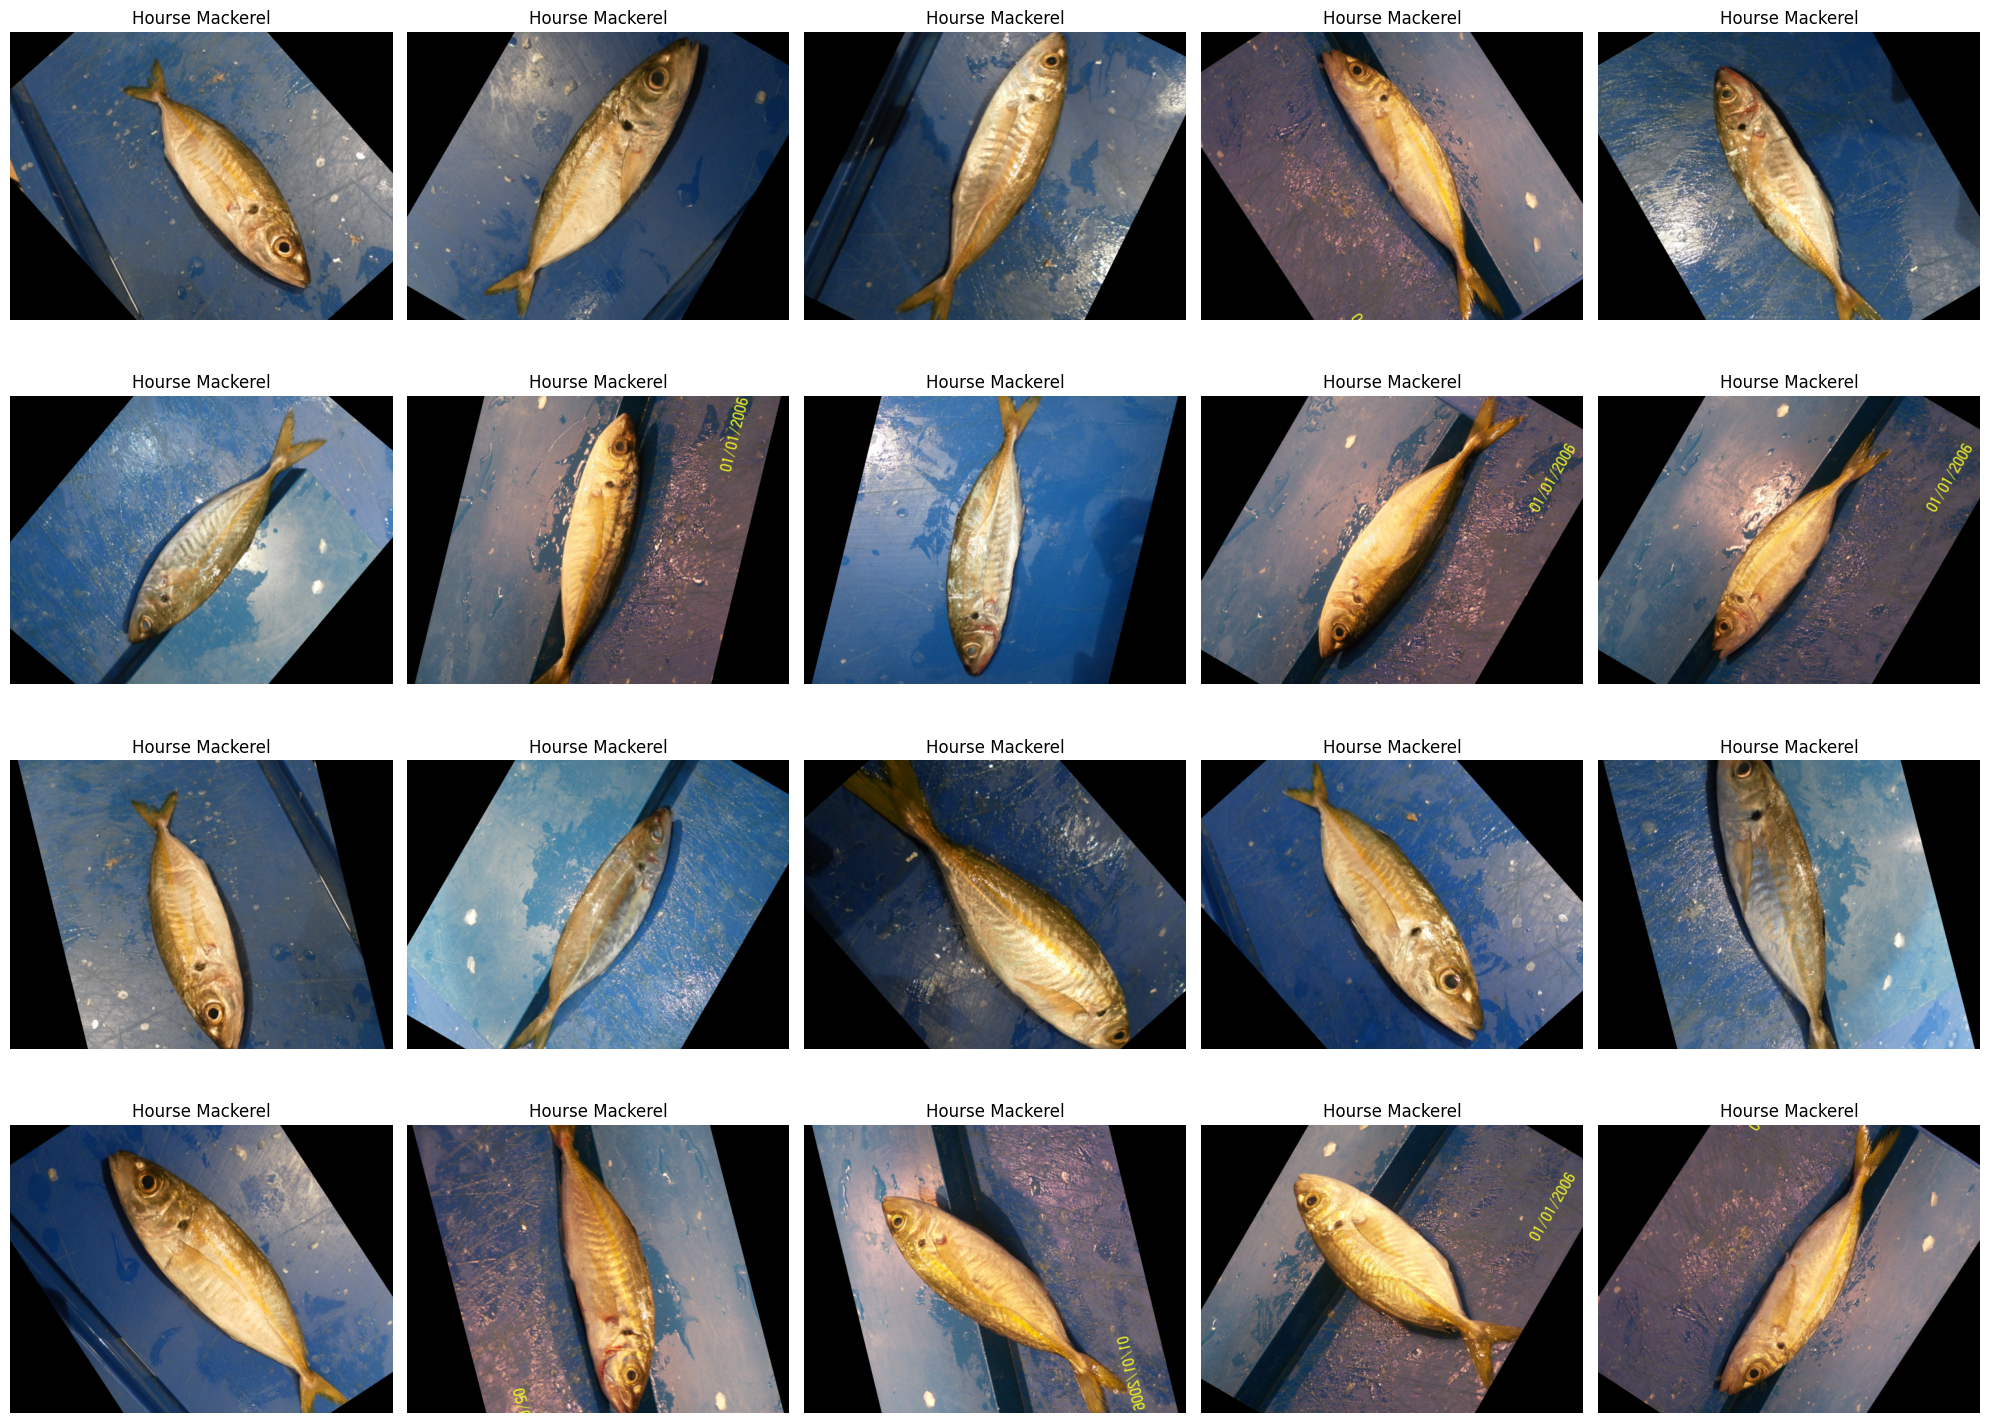

In [61]:
# Create a 4x5 grid (4 rows, 5 columns)
fig, axes = plt.subplots(4, 5, figsize=(20, 15))  # Set figure size for better display

# Display the first 20 images
for i, ax in enumerate(axes.flatten()):  # Flatten the 4x5 array of axes
    if i < len(data):  # Ensure we don't go out of bounds if there are fewer than 20 images
        img_path = data['path'][i]  # Get the image path
        img = Image.open(img_path)  # Open the image
        ax.imshow(img)  # Display the image
        ax.set_title(data['label'][i], fontsize=12)  # Set the label as the title
        ax.axis('off')  # Hide axes for a cleaner look
    else:
        ax.axis('off')  # Hide axes if there are no more images

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

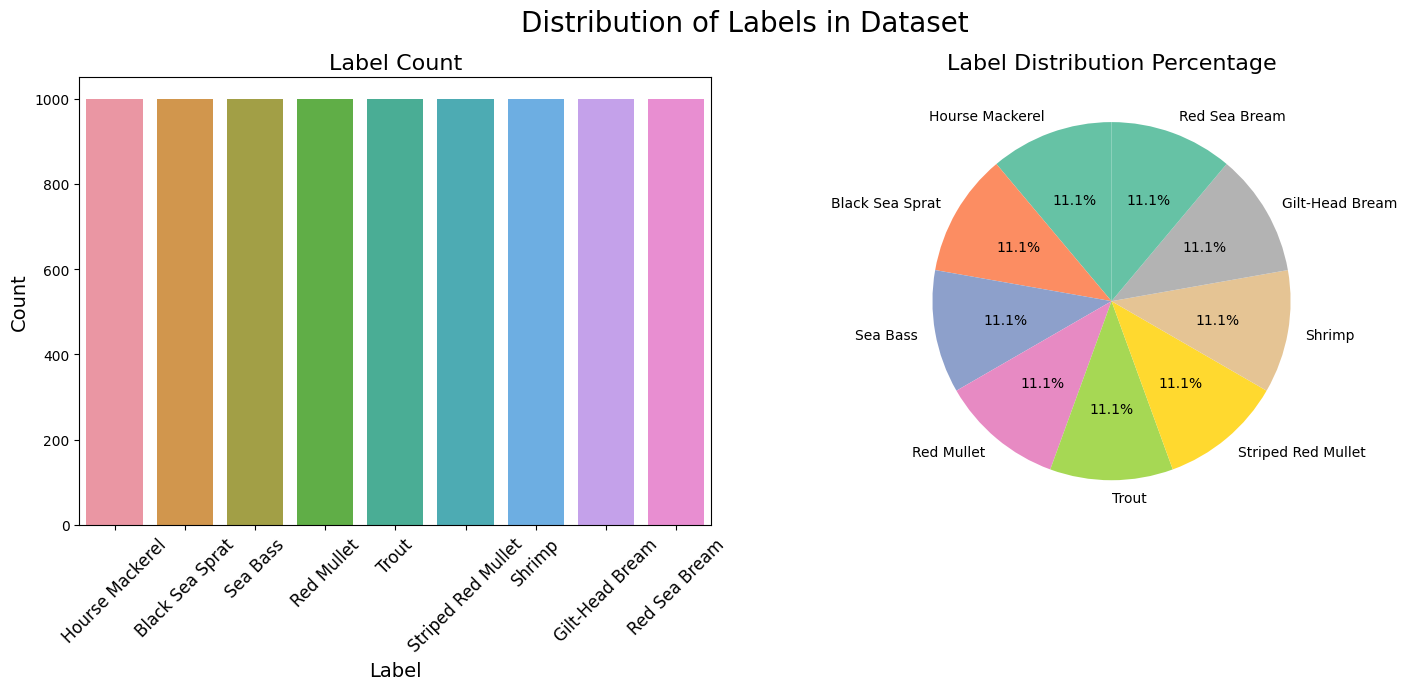

In [62]:
import seaborn as sns

# Set the color palette for consistency
sns.set_palette('Set2')

# Create the figure and subplots
plt.figure(figsize=(15, 7))

# Subplot 1: Bar plot showing the count of each label
plt.subplot(1, 2, 1)
sns.countplot(data=data, x='label')  # Adjust 'data' DataFrame and 'label' column
plt.xticks(rotation=45, fontsize=12)  # Rotate the x-axis labels for better readability
plt.title('Label Count', size=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Subplot 2: Pie chart showing the percentage distribution of each label
plt.subplot(1, 2, 2)
plt.pie(
    x=data['label'].value_counts().values,  # The counts of each label
    labels=data['label'].value_counts().index,  # The labels
    autopct='%1.1f%%',  # Display percentages with 1 decimal place
    colors=sns.color_palette('Set2'),  # Use seaborn color palette
    startangle=90  # Start the pie chart from a different angle
)
plt.title('Label Distribution Percentage', size=16)

# Set a super title for both plots
plt.suptitle('Distribution of Labels in Dataset', size=20)

# Show the plots
plt.tight_layout()
plt.show()

## Splitting

In [63]:
# Create X_train, y_train and X_temporary and y_temporary datasets from X and y.
X_train, X_temporary, y_train, y_temporary=train_test_split(X,y,train_size=0.8)

# Using the X_temporary and y_temporary dataset to create validaiton and test datasets.
X_val, X_test, y_val, y_test=train_test_split(X_temporary,y_temporary,train_size=0.5)

In [64]:
# Print the lengths of the X, X_train, X_val and X_test
print(f'Length of the dataset: {len(X)}')
print(f'Length of the training dataset: {len(X_train)}')
print(f'Length of the validation dataset: {len(X_val)}')
print(f'Length of the test dataset: {len(X_test)}')

Length of the dataset: 9000
Length of the training dataset: 7200
Length of the validation dataset: 900
Length of the test dataset: 900


## Training

In [69]:
# Build the ANN model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping



model = Sequential([
    Flatten(input_shape=(128, 128, 3)),  # Flatten the input images
    Dense(128, activation='relu'),  # First hidden layer
    #Dropout(0.2),  # Dropout layer
    Dense(64, activation='relu'),  # Second hidden layer    
    Dense(y.shape[1], activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with Early Stopping
history = model.fit(X_train, y_train, 
                    epochs=30, 
                    validation_data=(X_val, y_val), 
                    batch_size=32,
                    callbacks=[early_stopping])  



Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.2850 - loss: 5.0558 - val_accuracy: 0.4956 - val_loss: 1.3587
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5941 - loss: 1.1514 - val_accuracy: 0.6711 - val_loss: 0.9543
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7453 - loss: 0.7581 - val_accuracy: 0.7378 - val_loss: 0.7330
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.7517 - loss: 0.6939 - val_accuracy: 0.8178 - val_loss: 0.4999
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.8192 - loss: 0.5214 - val_accuracy: 0.7311 - val_loss: 0.7923
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.8395 - loss: 0.4570 - val_accuracy: 0.7689 - val_loss: 0.6718
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8667 - loss: 0.3685 - val_accuracy: 0.7944 - val_loss: 0.6030
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8809 - loss: 0.3307 - va

## Evaluate

In [70]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.2f}')



29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8571 - loss: 0.4541
Test accuracy: 0.85


## Visualize

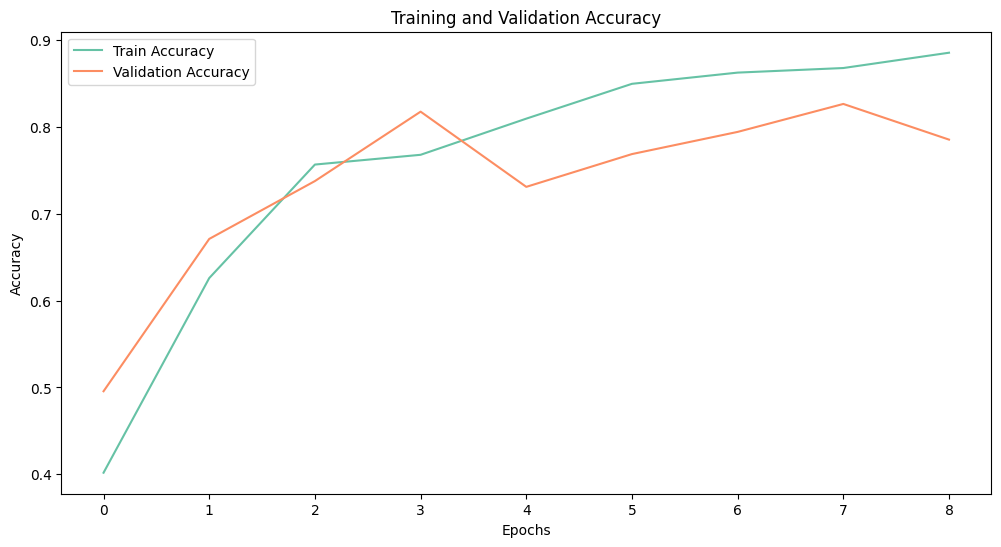

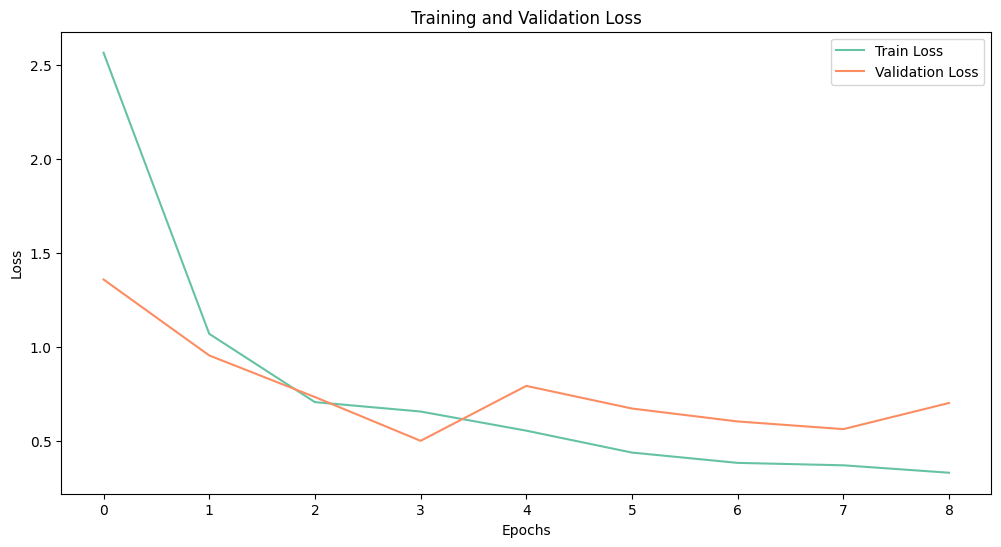

In [71]:
# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




## Confusion Matrix

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


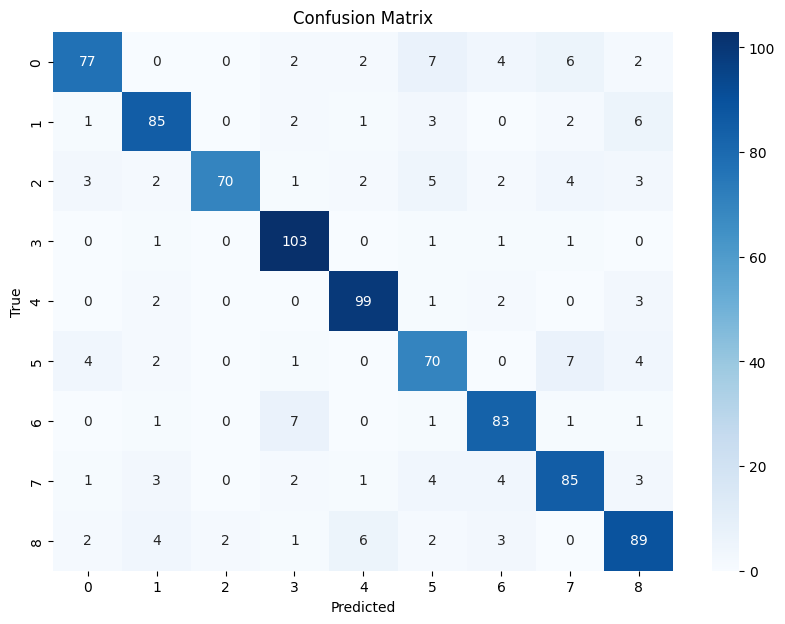

                    precision    recall  f1-score   support

   Black Sea Sprat       0.88      0.77      0.82       100
   Gilt-Head Bream       0.85      0.85      0.85       100
   Hourse Mackerel       0.97      0.76      0.85        92
        Red Mullet       0.87      0.96      0.91       107
     Red Sea Bream       0.89      0.93      0.91       107
          Sea Bass       0.74      0.80      0.77        88
            Shrimp       0.84      0.88      0.86        94
Striped Red Mullet       0.80      0.83      0.81       103
             Trout       0.80      0.82      0.81       109

          accuracy                           0.85       900
         macro avg       0.85      0.84      0.84       900
      weighted avg       0.85      0.85      0.85       900



In [72]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Make predictions on the test set
y_pred = model.predict(X_test)  # Run the model on the test data
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class labels

# Convert one-hot encoded y_test back to class labels
y_test_classes = np.argmax(y_test, axis=1)  # Get the true class labels

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)  # Compute the confusion matrix
plt.figure(figsize=(10, 7))  # Set figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')  # Plot the confusion matrix
plt.title('Confusion Matrix')  # Set title
plt.xlabel('Predicted')  # Label for the x-axis
plt.ylabel('True')  # Label for the y-axis
plt.show()  # Show the plot

# Classification Report
encoder = LabelEncoder()
encoder.fit(data['label'])  # Fit the encoder to the original labels

# Using the encoder classes to create the classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=encoder.classes_)  # Generate classification report
print(report)  # Print the report


